<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Начнём с импортов библиотек, функций и моделей.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
import math

from statsmodels.tsa.stattools import adfuller

from datetime import timedelta

from sklearn.metrics import mean_squared_error as mse

from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import train_test_split, TimeSeriesSplit, HalvingGridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb

STATE = np.random.RandomState(1234)

Ознакомимся с данными, попробуем сразу спарсить даты.

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates = [0])

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Видим: отсутствуют пропуски, данные сгруппированы по десятиминутным интервалам.  
Проверим наличие дубликатов.

In [3]:
df.duplicated().sum()

0

Дубликатов нет. Приведём дату к формату datetime и поставим в индекс.

In [4]:
df = df.sort_values(by = 'datetime').set_index(['datetime'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Вывод:
- Пропуски и дубликаты отсутствуют, данные приведены к соответствующим форматам и проиндексированы датой.

## Анализ

Напишем пару важных функций:  
- В первой зададим параметры, которые будем использовать для построения графиков
- Вторая функция будет выдавать tuple с индексами первого и последнего элемента временного отрезка заданной длины в часах.

In [5]:
def simple_plot(df, title):
    df.plot(grid = True, figsize = (12,8), title = title, 
            xlabel = 'Дата', ylabel = 'Количество заказов', alpha = 0.7);

In [6]:
def random_moment(hours):
    random_moment_index = np.random.randint(0, (len(df))-hours)
    return (random_moment_index, random_moment_index+hours)

Построим график наших данных.

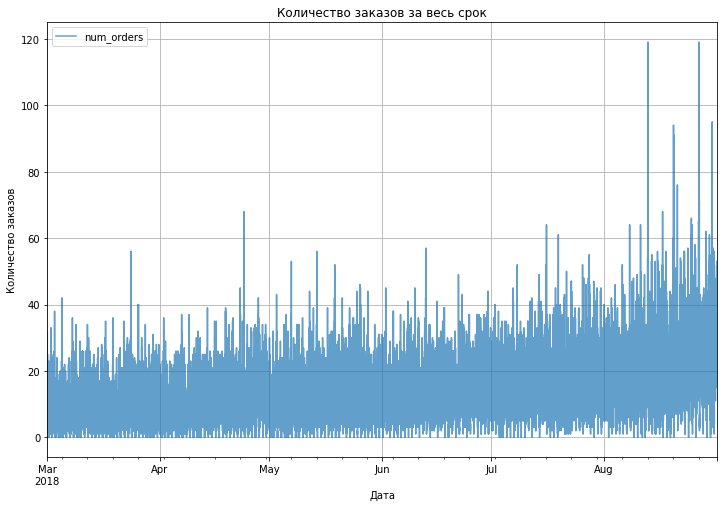

In [7]:
simple_plot(df, 'Количество заказов за весь срок')

Сгруппируем заказы по часам и посмотрим, как это повлияет на график.

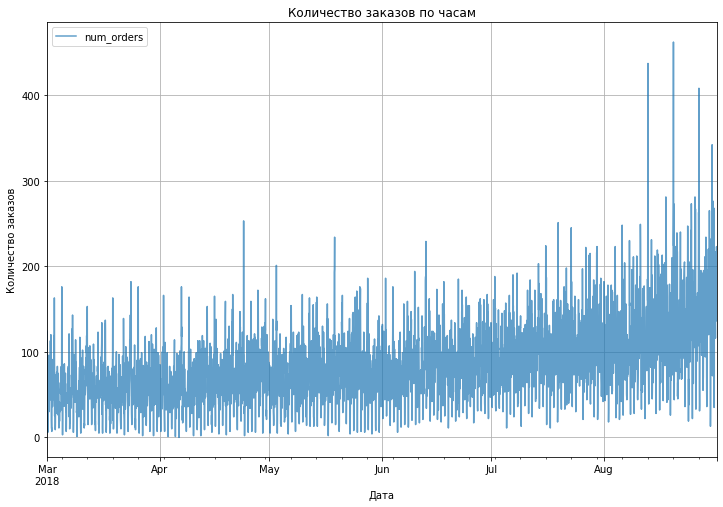

In [8]:
df = df.resample('1H').sum()
simple_plot(df, 'Количество заказов по часам')

Стало почище. Посмотрим, как выглядит динамика внутри случайных суток.

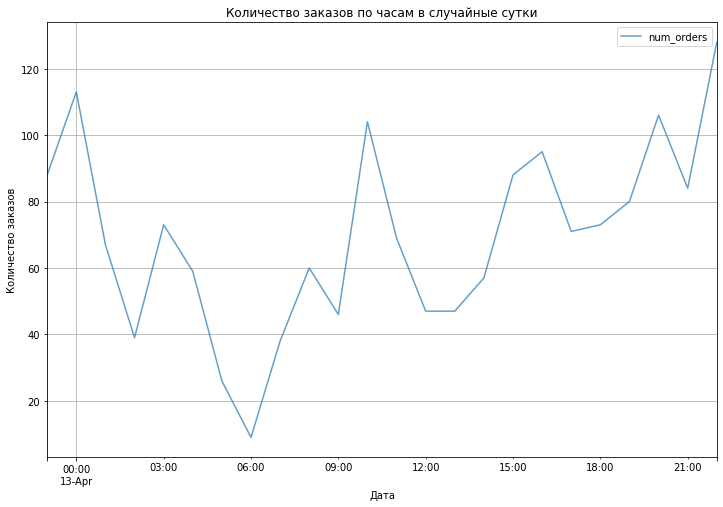

In [9]:
random_day = random_moment(24)
simple_plot(df.iloc[random_day[0]:random_day[1]],\
            'Количество заказов по часам в случайные сутки')

Видим утренний пик, вечений пик и пик ближе к полуночи. На работу, с работы в "третье место", оттуда - домой. Предположительно!

Сделаем ещё одну функцию - она будет считать среднее скользящее за прошедшие сутки и его стандартное отклонение.

In [10]:
def rolling(frame):
    frame['rolling_mean'] = frame['num_orders'].rolling(24).mean()
    frame['rolling_std'] = frame['num_orders'].rolling(24).std()
    return(frame)

Применим и взглянем на результат.

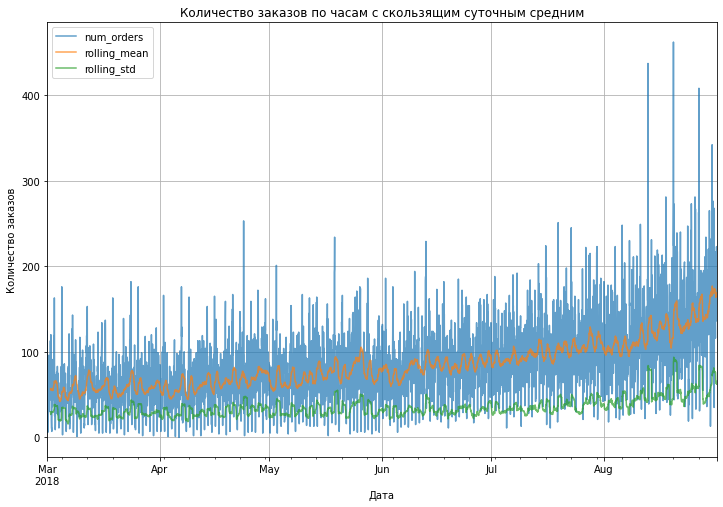

In [11]:
df_roll = df.copy()
df_roll = rolling(df_roll)
simple_plot(df_roll, 'Количество заказов по часам с скользящим суточным средним')

Видим, что наш временной ряд нестационарный: у нас возрастает и скользящее среднее, и стандартное отклонение, начиная с августа. Посмотрим на этот отрезок поближе.

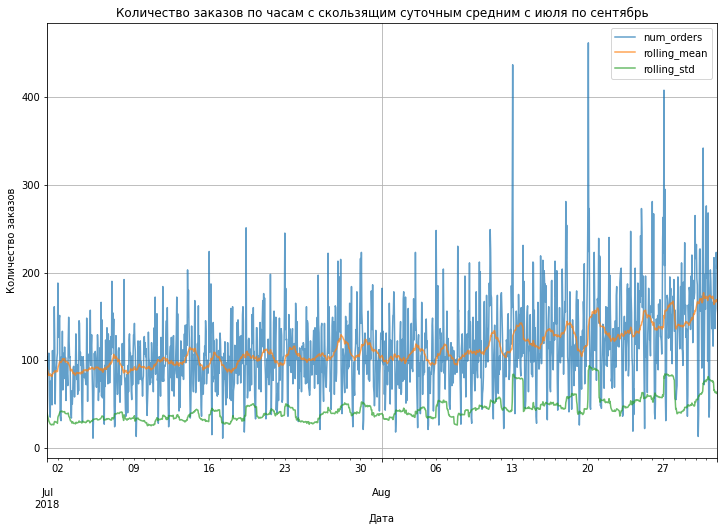

In [12]:
simple_plot(df_roll['2018-07':],\
            'Количество заказов по часам с скользящим суточным средним c июля по сентябрь')

Да, начиная с ~7 августа виден рост.

"Стационаризируем" данные. Найдем разность количества заказов против предыдущего часа. 

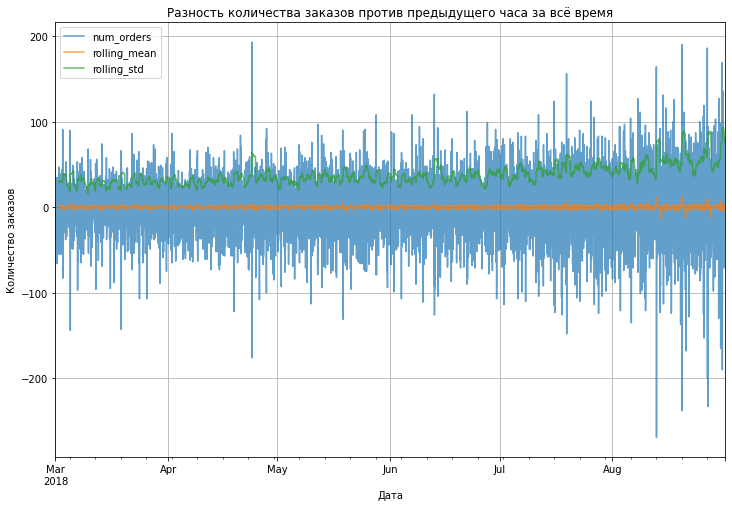

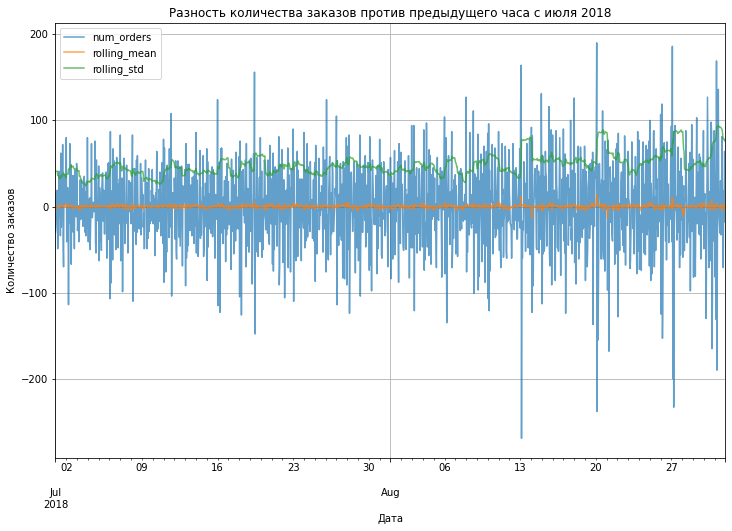

In [13]:
df_shifted = df-df.shift()
df_shifted = rolling(df_shifted)
simple_plot(df_shifted, 'Разность количества заказов против предыдущего часа за всё время')
simple_plot(df_shifted['2018-07':], 'Разность количества заказов против предыдущего часа с июля 2018')

Вот это уже похоже на стационарный ряд - в том числе на отрезке с интенсивным ростом.

Чтобы убедиться, проведём тест Дики-Фуллера.

In [14]:
ts = df['num_orders']
st_test = adfuller(ts, regression='ctt')

if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Наш ряд стационарный


Разложим наш ряд на тренд, сезонность и шум. Напишем функцию декомпозирования и построения графиков.

In [15]:
def decomp (data):
    decomposed = seasonal_decompose(data)
    decomposed_frame = pd.DataFrame(index = data.index)
    decomposed_frame['trend'] = decomposed.trend
    decomposed_frame['seasonal'] = decomposed.seasonal
    decomposed_frame['residue'] = decomposed.resid

    for column in decomposed_frame.columns:
        other_columns = decomposed_frame.columns.tolist()
        other_columns.remove(column)
        cycle_df = decomposed_frame.copy().drop(columns = other_columns)
        simple_plot(cycle_df, column)
        
    return decomposed_frame

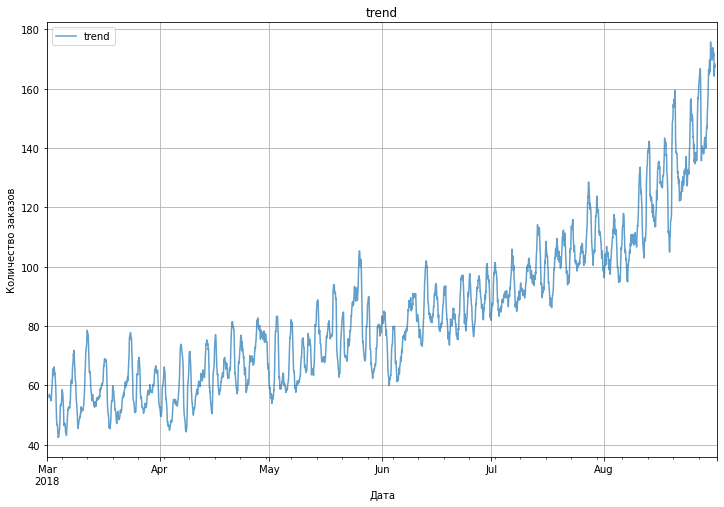

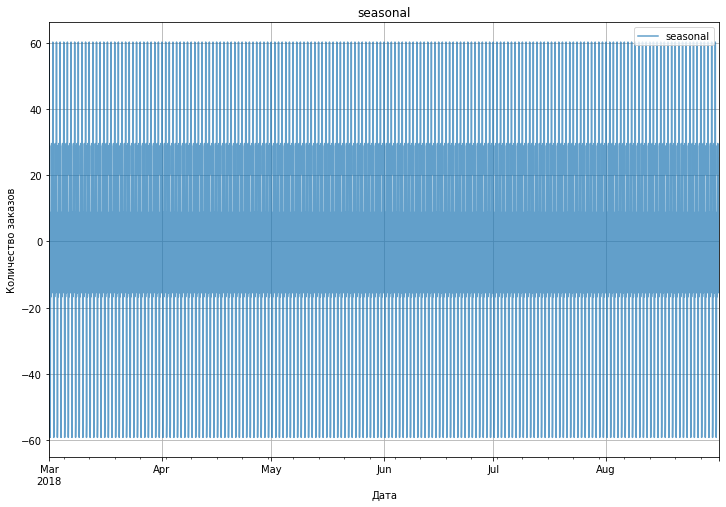

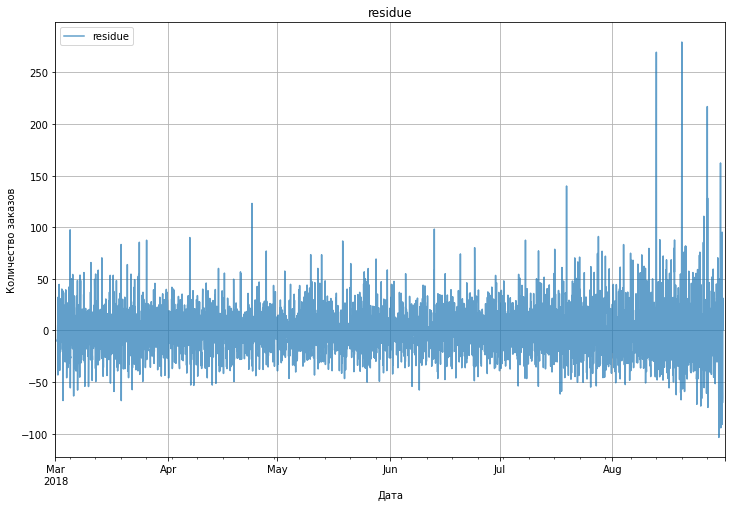

In [16]:
decomposed_df = decomp(df)

Видим уверенно растущий тренд. На сезонность посмотрим в разрезе трёх дней.

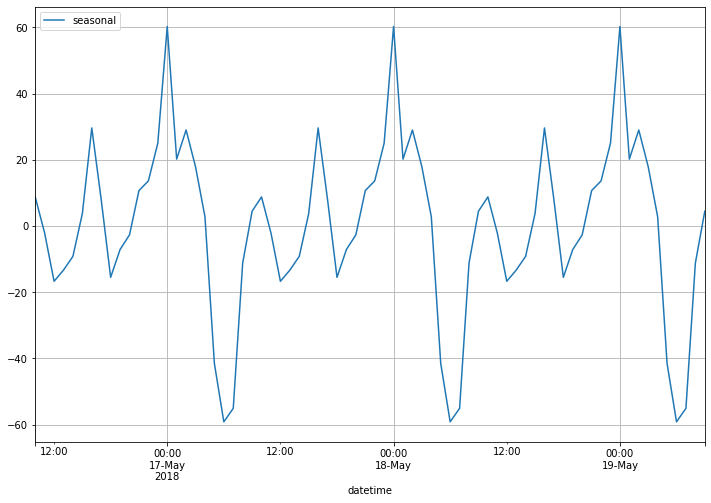

In [17]:
random_3day = random_moment(24*3)
decomposed_df.iloc[random_3day[0]:random_3day[1]]\
.plot(y = 'seasonal', figsize = (12,8),grid = True);

Утренний, вечерний, ночной пики. Как и заметили раньше.

Взглянем на сезонность в рамках случайной и календарной недели, случайного календарного месяца.

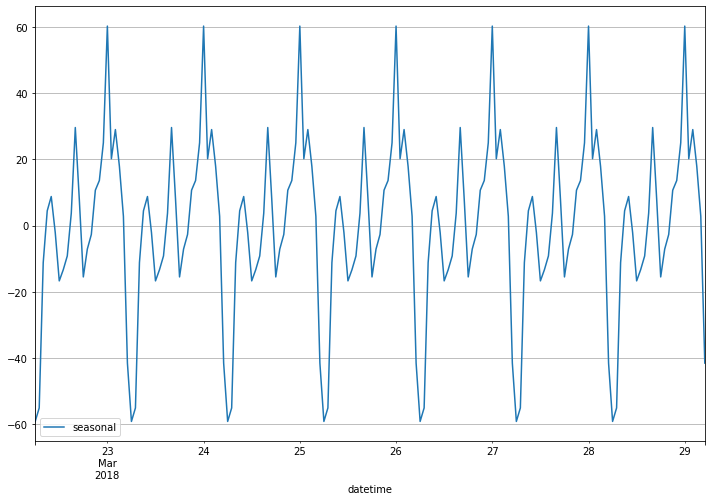

In [18]:
random_week = random_moment(24*7)
decomposed_df.iloc[random_week[0]:random_week[1]]\
.plot(y = 'seasonal', figsize = (12,8),grid = True);

Попробуем сделать ресэмплинг по дням и увидеть внутринедельные тренды.

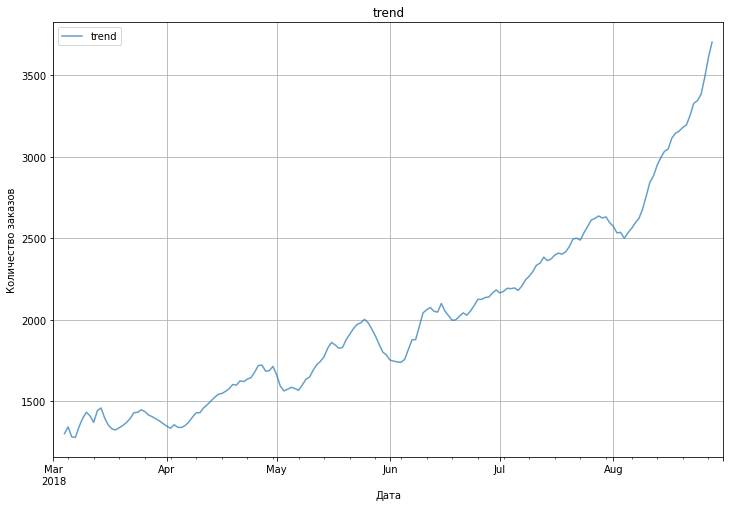

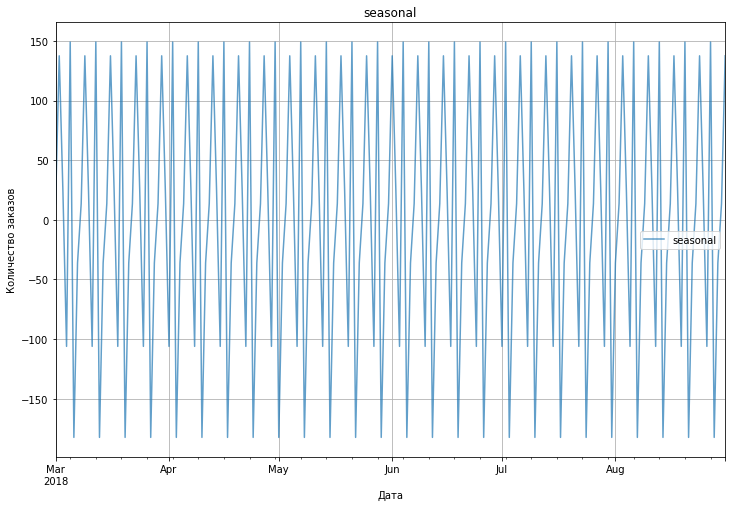

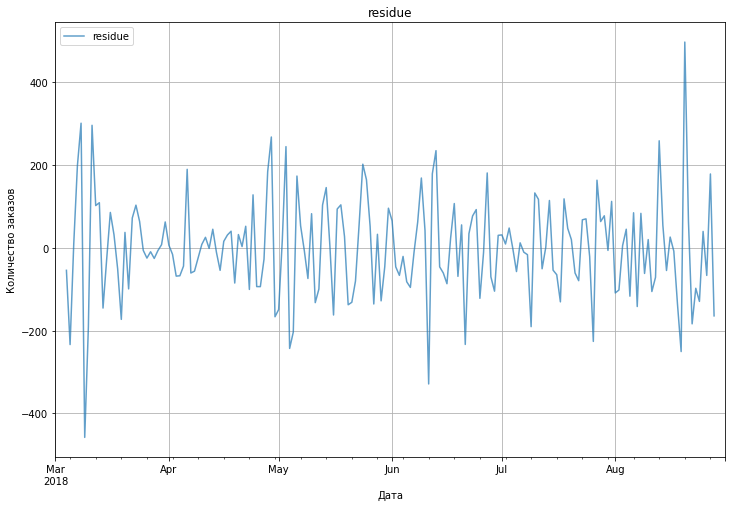

In [19]:
df_days = df.copy().resample('1D').sum()
decomposed_days = decomp(df_days)

Тренд на рост подтвердился. 
И как ожидалось, видна другая сезональность.  Посмотрим поближе - на случайную неделю!

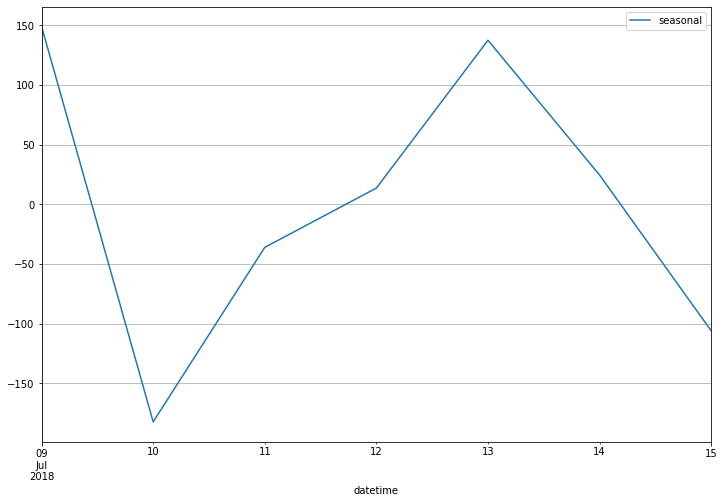

In [20]:
df_days['dayofweek'] = df_days.index.dayofweek
monday = df_days.query('dayofweek == 0').sample(1).index
sunday = monday + timedelta (days = 6)

week = [monday.strftime('%Y-%m-%d').tolist()[0],sunday.strftime('%Y-%m-%d').tolist()[0]]

decomposed_days[week[0]:week[1]]\
.plot(y = 'seasonal', figsize = (12,8),grid = True);

Видим пик поездок в понедельник, просадку во вторник, далее постепенный рост к пятнице и падение в субботу и воскресенье.  

Гипотетически: в понедельники люди прилетают в командировки, и постепенно отбывают, увеличивая количество поездок в последующие дни. 
В пятницу к ним добавляются люди, которые едут на такси до вокзалов и аэропортов, чтобы улететь или уехать куда-то отдохуть на выходные, и люди, которые после тяжелой трудовой недели едут увеселяться и обратно. 

По субботам все валяются в постели целый день, по воскресеньям - тем более. 

### Вывод:
- Выделяются три пика заказов - утро, вечер и околополночь.
- Просадка по количеству заказов - околорассветные часы. Кто был не дома, тот вернулся, кто был дома, тот спит.
- Видна внутринедельная тенденция с пиками в понедельник и пятницу и просадкой во вторник. 
- Видна тенденция к росту количества заказов. Объяснить это можно или годовой сезонностью или ростом числа пользователей, но точно установить причину невозможно - недостаточно данных. 

## Обучение

Напишем функцию для создания признаков и добавим их в наш датафрейм. Затем разобъём признаки на целевой и обучающие, а далее - на выборки.

In [21]:
def make_features(data, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    
    for lag in range(1,49):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

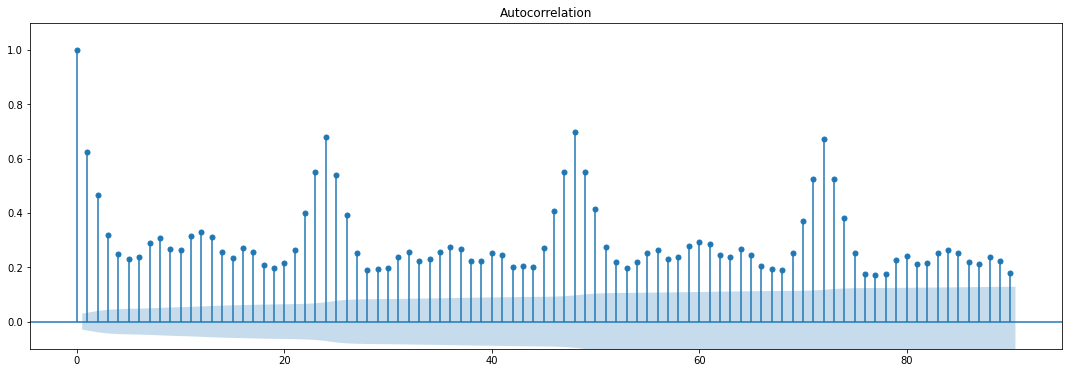

In [22]:
# Код ревьюера
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(df['num_orders'],lags= 90)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 




In [23]:
make_features (df, 24)

df = df.dropna()

features = df.drop(columns = 'num_orders')
target = df['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, 
                                                                            test_size=0.1)
sample_list = ['train','test']
split_list = ['features', 'target']

for sample in sample_list:
    for split in split_list:
        print (f'Shape of {split}_{sample}:', eval('_'.join([split,sample])).shape,'\n')

Shape of features_train: (3931, 52) 

Shape of target_train: (3931,) 

Shape of features_test: (437, 52) 

Shape of target_test: (437,) 



Теперь напишем функцию для построения сравнительного графика предсказаний и факта на случайной неделе.

In [24]:
def compare_week (model,features):
    
    predict = pd.DataFrame(model.predict(features), index=features.index)
    
    random_week = random_moment(24*7)
    
    plt.figure(figsize=(12,8))
    
    plt.plot(target[random_week[0]:random_week[1]], color='black', alpha=0.4)
    plt.plot(predict[random_week[0]:random_week[1]], color='blue', alpha=0.5)
    
    plt.title('Сравнение предсказаний и факта в случайную неделю')
    
    plt.ylabel('Количество заказов')
    plt.xlabel('Дата')
    plt.legend(['Реальные', 'Предсказанные'])
    
    plt.show()

И напишем функцию поиска гиперпараметров, построения предсказаний и графиков. Целевая метрика - RMSE.

In [25]:
def search_time_save(model, parameters = {}, features = features_train,target = target_train):
    
    tscv = TimeSeriesSplit(n_splits=15)
    grid = HalvingGridSearchCV(model, parameters, 
                         scoring = 'neg_root_mean_squared_error', cv = tscv, verbose = 1)
    start = time.time()
    grid.fit(features, target)
    stop = time.time()
    
    learn_time = stop-start
    
    score = abs(grid.best_score_)
    print()
    print (f"Для выбранной модели наилучший результат = {score:0.2f} за {learn_time:0.2f} сек.")
    model_dict = {'score':score,
                  'learn_time':learn_time,
                  'fit_time':grid.refit_time_,
                  'params':grid.best_params_,
                  'model':grid.best_estimator_}
    
    compare_week(model_dict['model'], features)
    
    return model_dict

Для начала, оценим линейную Ridge модель.

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 3931
max_resources_: 3931
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 3931
Fitting 15 folds for each of 1 candidates, totalling 15 fits

Для выбранной модели наилучший результат = 24.08 за 4.15 сек.


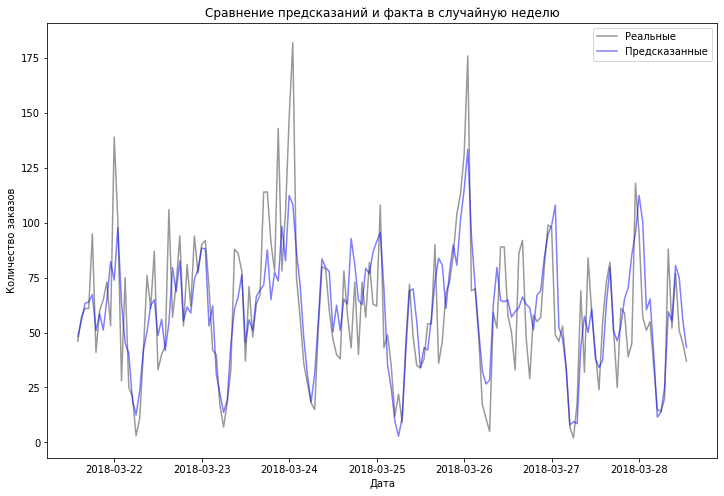

In [26]:
model = RidgeCV()

ridge_dict = search_time_save(model)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 145
max_resources_: 3931
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 30
n_resources: 145
Fitting 15 folds for each of 30 candidates, totalling 450 fits
----------
iter: 1
n_candidates: 10
n_resources: 435
Fitting 15 folds for each of 10 candidates, totalling 150 fits
----------
iter: 2
n_candidates: 4
n_resources: 1305
Fitting 15 folds for each of 4 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 2
n_resources: 3915
Fitting 15 folds for each of 2 candidates, totalling 30 fits

Для выбранной модели наилучший результат = 27.11 за 6.26 сек.


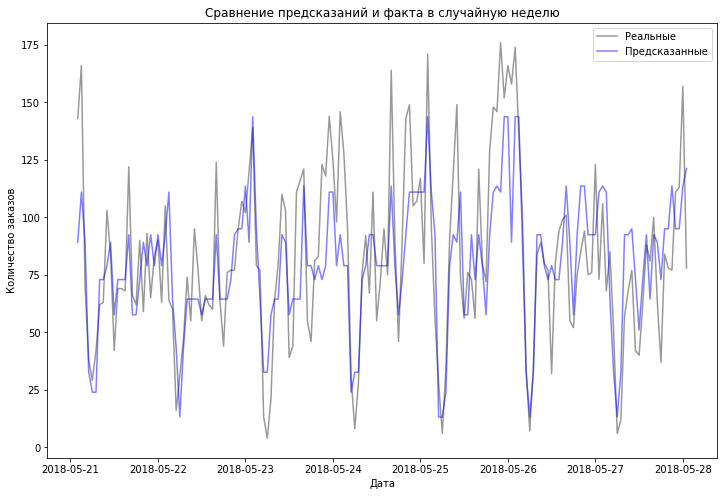

In [27]:
model = DecisionTreeRegressor()

parameters = {'max_depth': [*range (1,31)],
              
             'random_state': [STATE]}

tree_dict  = search_time_save(model, parameters)

Далее посмотрим на модель случайного леса.

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 145
max_resources_: 3931
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 40
n_resources: 145
Fitting 15 folds for each of 40 candidates, totalling 600 fits
----------
iter: 1
n_candidates: 14
n_resources: 435
Fitting 15 folds for each of 14 candidates, totalling 210 fits
----------
iter: 2
n_candidates: 5
n_resources: 1305
Fitting 15 folds for each of 5 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 2
n_resources: 3915
Fitting 15 folds for each of 2 candidates, totalling 30 fits

Для выбранной модели наилучший результат = 23.06 за 467.17 сек.


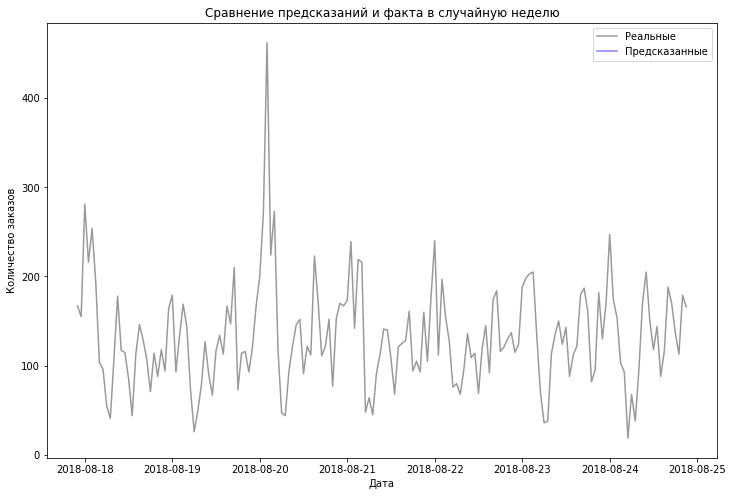

In [28]:
model = RandomForestRegressor()

parameters = {'n_estimators': [*range(50,150,10)],
             'max_depth': [*range (8,12)],
             'random_state': [STATE]}

forest_dict = search_time_save(model, parameters)

Теперь попробуем две модели с градиентным бустингом: GradientBoostingRegressor из scikit-learn и lightGBM

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 145
max_resources_: 3931
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 60
n_resources: 145
Fitting 15 folds for each of 60 candidates, totalling 900 fits
----------
iter: 1
n_candidates: 20
n_resources: 435
Fitting 15 folds for each of 20 candidates, totalling 300 fits
----------
iter: 2
n_candidates: 7
n_resources: 1305
Fitting 15 folds for each of 7 candidates, totalling 105 fits
----------
iter: 3
n_candidates: 3
n_resources: 3915
Fitting 15 folds for each of 3 candidates, totalling 45 fits

Для выбранной модели наилучший результат = 22.71 за 332.27 сек.


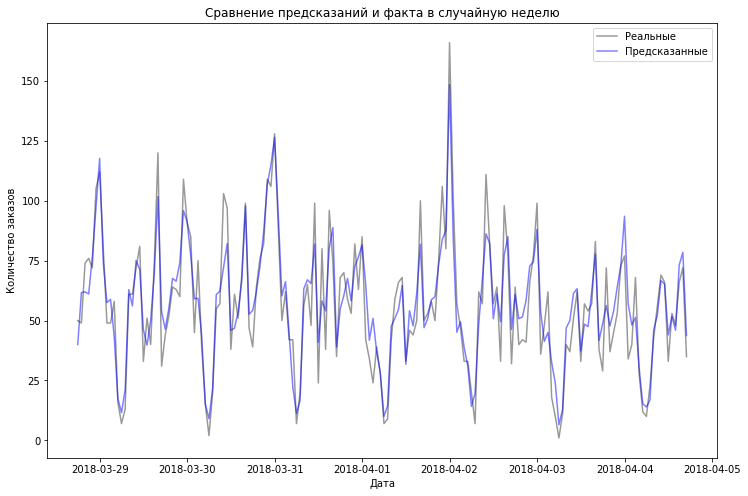

In [29]:
model = lgb.LGBMRegressor(boosting_type='gbdt', objective = 'regression', metric = 'RMSE')

parameters =  {'learning_rate':[0.05,0.1,0.15],
              'random_state': [STATE],
              'n_estimators':[*range(50,151,25)],
              'min_child_samples':[*range(20,51,10)]
}

lgb_dict = search_time_save(model, parameters)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 145
max_resources_: 3931
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 60
n_resources: 145
Fitting 15 folds for each of 60 candidates, totalling 900 fits
----------
iter: 1
n_candidates: 20
n_resources: 435
Fitting 15 folds for each of 20 candidates, totalling 300 fits
----------
iter: 2
n_candidates: 7
n_resources: 1305
Fitting 15 folds for each of 7 candidates, totalling 105 fits
----------
iter: 3
n_candidates: 3
n_resources: 3915
Fitting 15 folds for each of 3 candidates, totalling 45 fits

Для выбранной модели наилучший результат = 23.03 за 258.46 сек.


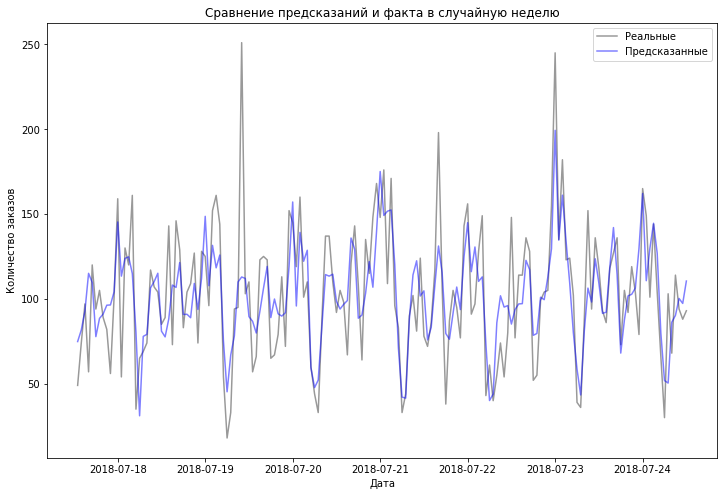

In [30]:
model = GradientBoostingRegressor()

parameters =  {'learning_rate':[0.05,0.1,0.15],
              'random_state': [STATE],
              'n_estimators':[*range(50,151,25)],
              'min_samples_leaf':[*range(20,51,10)]
}

sklearn_gb_dict = search_time_save(model, parameters)

In [31]:
dict_list = [ridge_dict, tree_dict, forest_dict, lgb_dict, sklearn_gb_dict]

model_scores = pd.DataFrame(dict_list, index = ['ridge', 'tree','forest','lgb', 'sklearn_gb']).drop(columns=['params','model'])\
.sort_values(by='score')
model_scores

,score,learn_time,fit_time
lgb,22.707099,332.274234,2.485435
sklearn_gb,23.025751,258.457385,4.497859
forest,23.061926,467.172002,7.125520
ridge,24.080152,4.151476,0.294761
tree,27.105514,6.262453,0.039548


In [32]:
best_model = sklearn_gb_dict['model'] 

### Вывод: 

Наилучшие результаты по совокупности времени подбора гиперпараметров и точности предсказания показала модель GradientBoostingRegressor.

## Тестирование

Применим нашу наилучшую обученную модель на тестовую выборку и выведем сравнительный график за весь период, содержащийся в тестовой выборке.

На тестовой выборке результат наилучшей модели = 41.71


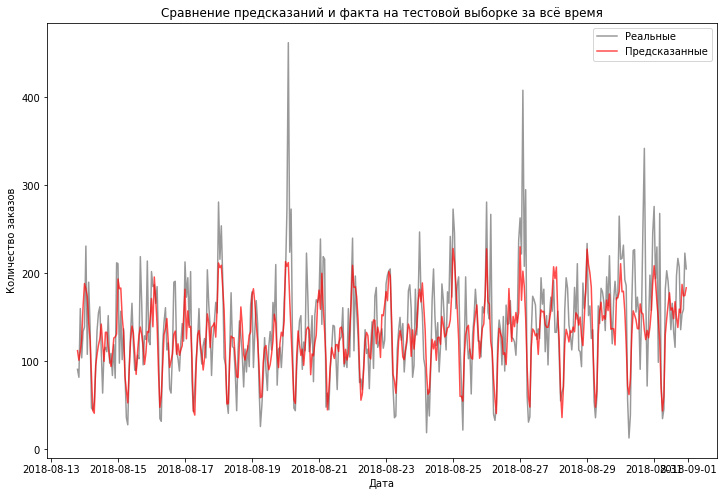

In [33]:
test_predictions = best_model.predict(features_test)
test_score = mse(target_test,test_predictions)**0.5
print(f'На тестовой выборке результат наилучшей модели = {test_score:.2f}')

predict = pd.DataFrame(test_predictions, index = features_test.index)

plt.figure(figsize=(12,8))
    
plt.plot(target_test, color='black', alpha=0.4)
plt.plot(predict, color='red', alpha=0.7)
    
plt.title('Сравнение предсказаний и факта на тестовой выборке за всё время')
    
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
    
plt.show()

### Выводы:

- Модель подходит для предсказания: метрика лучше требуемой (RMSE < 48).
- Модель неплохо предсказывает наличие или отсутствие пика или просадки, но неидеально предсказывает его величину. Требуется выборка большего размера.

## Общий вывод:
- Данные были подготовлены для анализа и проанализированы на стационарность.
- Были созданы признаки, обучены и сравнены модели. Наилучшие результаты показала модель lightGBM.
- Целевая метрика на тестовой выборке меньше (= лучше) пороговой. Модель можно использовать, но предпочтительно собрать или сгенерировать больше данных - потенциально улучшится качество предсказания. 